In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

FIGURE_DIR = "figures/"

In [75]:
TRAIN_DATA_DIR = "train_data/"
filenames = [
    "VAE_CELL_CNN_latent2_mean_loss_data.csv",
    "VAE_CELL_CNN_latent8_mean_loss_data.csv",
    "VAE_CELL_CNN_latent16_mean_loss_data.csv",
    "VAE_CELL_CNN_latent32_mean_loss_data.csv",
    "VAE_CELL_CNN_latent64_mean_loss_data.csv",
    "VAE_CELL_CNN_latent128_mean_loss_data.csv",
    "VAE_CELL_CNN_latent256_mean_loss_data.csv",
]

dfs = [pd.read_csv(TRAIN_DATA_DIR + filename) for filename in filenames]



In [76]:
def extract_latent_dim(filename):
    return filename.split("_")[3].split("latent")[1]

# combine all the dataframes
df_overall = pd.DataFrame(columns=["latent_dim"] + dfs[0].columns.tolist())
for filename, df in zip(filenames, dfs):
    
    latent_dim = extract_latent_dim(filename)
    df["latent_dim"] = latent_dim
    df_overall = pd.concat([df_overall, df])



C:\Users\Otto\AppData\Local\Temp\ipykernel_10868\4086857407.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [77]:
def prepare_df(df):
    df.columns = df.columns.str.replace("_", " ")
    # df.columns = df.columns.str.replace("loss", "")
    df.columns = df.columns.str.strip()
    return df
# round to 2 decimal places
df_overall = df_overall.round(3)
df_overall



,latent_dim,train_loss,train_mse_loss,train_kld_loss,val_loss,val_mse_loss,val_kld_loss,test_loss,test_mse_loss,test_kld_loss
0,2,217.022,209.691,7.331,197.489,190.514,6.975,184.232,177.776,6.456
1,2,195.241,188.399,6.842,193.323,186.466,6.858,184.232,177.776,6.456
2,2,192.215,185.774,6.441,190.925,184.502,6.422,184.232,177.776,6.456
3,2,190.937,184.701,6.236,190.577,184.456,6.121,184.232,177.776,6.456
4,2,192.659,186.240,6.420,191.326,184.803,6.523,184.232,177.776,6.456
...,...,...,...,...,...,...,...,...,...,...
45,256,87.635,54.181,33.454,88.280,54.740,33.541,88.177,54.581,33.596
46,256,87.598,54.141,33.458,88.030,54.538,33.492,88.177,54.581,33.596
47,256,87.581,54.131,33.450,88.353,54.308,34.045,88.177,54.581,33.596
48,256,87.544,54.087,33.457,88.211,54.735,33.476,88.177,54.581,33.596


In [78]:
# there are 50 epochs
# use index as x-axis
fig = px.line(df_overall, x=df_overall.index, y="train_loss", color="latent_dim")
fig.update_layout(
    title="Training Loss vs Epochs",
    xaxis_title="Epochs",
    yaxis_title="Training Loss",
)
fig.show()


In [79]:
# extract all the "last" rows
df_last = df_overall.groupby("latent_dim").tail(1)
prepare_df(df_last).to_latex(index=False, escape=False, buf=FIGURE_DIR + "final_loss_table.tex", float_format="%.2f")
# df_last



# fig = px.bar(df_last, x="name", y="train_loss")
# fig.update_layout(
#     title="Final Training Loss",
#     xaxis_title="Latent Dimension",
#     yaxis_title="Training Loss",
# )
# fig.show()

# Compare models reconstruction on some samples

In [80]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset_tools import OwnDataset, make_train_test_val_split
import matplotlib

cuda = torch.cuda.is_available()

In [81]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 64
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



488396 4883 1526 1221


## Load the models we want to compare

In [86]:
# there are 3 different unsupervised models to choose from on the cell dataset
from models import VAE_CELL_CNN, VAE_LAFARGE, CELL_CNN_AutoEncoder
from loss_functions import loss_function
# import mse loss


# now we load the saved models into the model class
MODEL_DIR = "trained_models/"

vae_cnn_own = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
vae_cnn_own.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own.__class__.__name__}_latent{vae_cnn_own.latent_dim}_b1_mean_hpc_best_model.pth"))
# vae_lafarge = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
# vae_lafarge.load_state_dict(torch.load(MODEL_DIR + f"{vae_lafarge.__class__.__name__}_latent{vae_lafarge.latent_dim}_best_model.pth"))

ae_cnn_own = CELL_CNN_AutoEncoder(latent_dim=256)
ae_cnn_own.load_state_dict(torch.load(MODEL_DIR + f"{ae_cnn_own.__class__.__name__}_latent{ae_cnn_own.latent_dim}_best_model.pth"))


vae_cnn_own_b0 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
vae_cnn_own_b0.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_b0.__class__.__name__}_latent{vae_cnn_own_b0.latent_dim}_b0_best_model.pth"))




# models = [vae_cnn_own]
models = [vae_cnn_own, ae_cnn_own, vae_cnn_own_b0]
# models = [ae_cnn_own]



## Evaluate performance on test set given by the loss

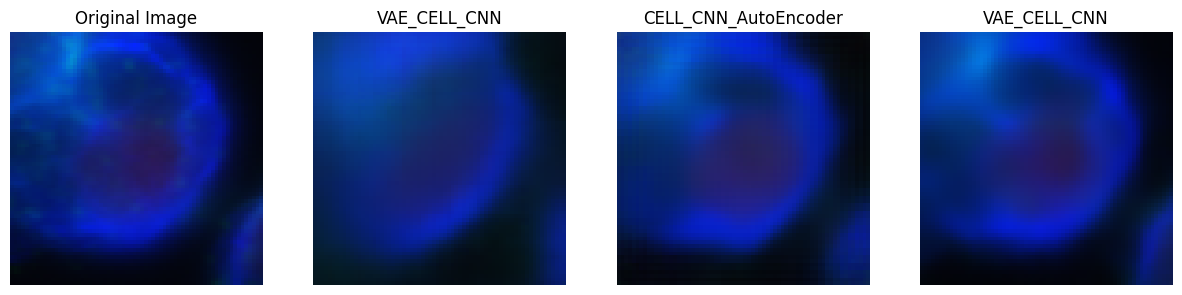

In [87]:
# Given an input image, create a reconstruction of the image using each model


def reconstruct_image(model, image):
    with torch.no_grad():
        model.eval()
        image = image.unsqueeze(0)
        output = model(image)
        if isinstance(output, dict):
            x_hat = output["x_hat"]
        else:
            x_hat = output
        return x_hat.squeeze(0)
    
x, y = next(iter(train_loader))


# plot the original image and the reconstructed image
# reconstruct_image(vae_cnn_own, x[0]).shape
reconstruct_image(ae_cnn_own, x[0]).shape




def plot_reconstructions(models, image):
    fig, ax = plt.subplots(1, len(models)+1, figsize=(15, 5))
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].set_axis_off()
    for i, model in enumerate(models):
        x_hat = reconstruct_image(model, image)
        ax[i+1].imshow(x_hat.permute(1, 2, 0))
        ax[i+1].set_title(model.__class__.__name__)
        ax[i+1].set_axis_off()
    plt.axis("off")
    plt.show()

plot_reconstructions(models, x[0])



# Classification data analysis

## Gather all the train and test accuracies in joint table

In [28]:
TRAIN_DATA_DIR = "train_data/"
filenames = ["LatentClassifier_2_latent2_mean_data.csv", 'LatentClassifier_2_latent256_mean_data.csv']

# dfs = [pd.read_csv(TRAIN_DATA_DIR + filename) for filename in filenames]